# Lab 04: Image Matching and Image Stitching

In this lab, you'll implement and play with the algorithms taught in course 5 and 6. 

- Student Name: 汪珉凯
- Student ID: 3220100975
- Date: 2024-10-24

## Part I: Image Matching

### Task 1: Find corners with harris detector

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

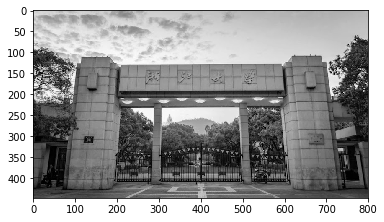

In [2]:
# Let's load an example image
filename = 'building.jpeg'
img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
fig = plt.imshow(img, cmap='gray')

Step 1. Compute the covariance matrix at each point

$$H=\begin{bmatrix}I_x^2& I_xI_y\\I_xI_y &I_y^2\end{bmatrix}$$

where $I_x=\frac{\partial f}{\partial x}, I_y=\frac{\partial f}{\partial y}$.

In practice, we can further apply a 2D gaussian filter G to smooth H

$$ H'_{i,j,c} = \sum_{m=1}^{W} \sum_{n=1}^{W} G_{m,n} \cdot H_{i+m-\frac{W+1}{2},j+n-\frac{W+1}{2},c} $$

In [3]:
# normalize image to [0,1]
img_float = img.astype(np.float32) / 255.0

# use sobel operator at every location
sobel_x = cv2.Sobel(img_float, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(img_float, cv2.CV_64F, 0, 1, ksize=3)


# compute H 
H = np.zeros((img.shape[0], img.shape[1], 4))
H[..., 0] = sobel_x * sobel_x
H[..., 1] = sobel_x * sobel_y
H[..., 2] = sobel_x * sobel_y
H[..., 3] = sobel_y * sobel_y

# gaussian weights, what window-size should be used?
window_size = 7
gaussian_kernel_1d = cv2.getGaussianKernel(window_size, 0.5)
gaussian_kernel_2d = np.outer(gaussian_kernel_1d, gaussian_kernel_1d.transpose())
H = cv2.filter2D(H, -1, gaussian_kernel_2d)


Step 2. Harris response

Theoretically, we can compute eigenvalues

$H=\begin{bmatrix}a&b\\c&d\end{bmatrix}\quad \lambda_\pm=\frac{1}{2}((a+d)\pm\sqrt{4bc+(a-d)^2})$

and then classify points using eigenvalues of H, like:

<img src="https://opencv24-python-tutorials.readthedocs.io/en/latest/_images/harris_region.jpg" alt="drawing" width="200"/>

However, computing eigenvalues are expensive, so we use the following alternative:

$$f=\frac{\lambda_1 \lambda_2}{\lambda_1+\lambda_2}=\frac{determinant(H)}{trace(H)}$$

where $det(\begin{bmatrix}a&b\\c&d\end{bmatrix})=ad-bc$,   and $trace(\begin{bmatrix}a&b\\c&d\end{bmatrix})=a+d$

In [4]:
# compute harris response
det_H = H[..., 0] * H[..., 3] - H[..., 1] * H[..., 2]
trace_H = H[..., 0] + H[..., 3]
f = det_H / trace_H

e:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


Step 3. Threshold $f$ and visualize

we skip non-maximum suppression operation here. You only need to visualize the thresholded harris response map.

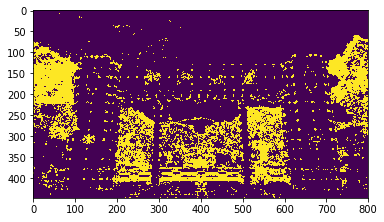

In [5]:
# threshold and visualize the binary response map with plt.imshow(f_binary)
# the threshold is a hyperparameter, try different values
f_binary = f > 0.008
plt.imshow(f_binary)

Further reading:

[【计算机视觉】2. 特征点检测：Harris, SIFT, SURF, ORB](https://zhuanlan.zhihu.com/p/36382429)

### Task 2: SIFT

To do this task, read [opencv documentation on SIFT](https://docs.opencv.org/4.5.4/d7/d60/classcv_1_1SIFT.html) first, and use it for local feature detection and description.

In [6]:
# load an image
img0 = cv2.imread("1.jpeg", cv2.IMREAD_GRAYSCALE)
img1 = cv2.imread("2.jpeg", cv2.IMREAD_GRAYSCALE)

In [7]:
# creat sift extractor (detector + descriptor)
SIFT = cv2.SIFT_create()

# get the detector and descriptor
kpts0, descs0 = SIFT.detectAndCompute(img0, None)
kpts1, descs1 = SIFT.detectAndCompute(img1, None)

For SIFT descriptors, people usually match them with ratio-test.

(1) Please list the main advantage of ratio-test in matching SIFT descriptors.  


(2) Do you think mutual-nearest-neighbor method can also work?  


 <span style="color:red">
 
 
(1)Answer:  
1.通过设置比率阈值，显著降低了错误匹配的数量，从而提高了特征匹配的整体准确性。  
2.比率测试利用了关键点之间的几何关系，从而使匹配更可靠。由于SIFT描述符旨在捕捉局部图像特征，比率测试能够利用这些属性来保持匹配的完整性。  
3.比率测试相对简单，计算效率高，适合实时应用。  

(2)Answer:  
一般情况下MNN也可以用来匹配关键点，但是一般来说开销会更大。
 
 
 </span>

In [8]:
# compute descriptor distance
#create a matcher
matcher = cv2.BFMatcher_create(cv2.NORM_L2)
# match descriptors
matches = matcher.knnMatch(descs0, descs1,2)
# calculate good matches
good_matches = []
for m,n in matches:
    if m.distance < 0.7 * n.distance:
        good_matches.append(m)

mkpts0= [kpts0[m.queryIdx].pt for m in good_matches]#queryidx is the index of the descriptor in the first image
mkpts1= [kpts1[m.trainIdx].pt for m in good_matches]#trainidx is the index of the descriptor in the second image

And visualize the final matches.

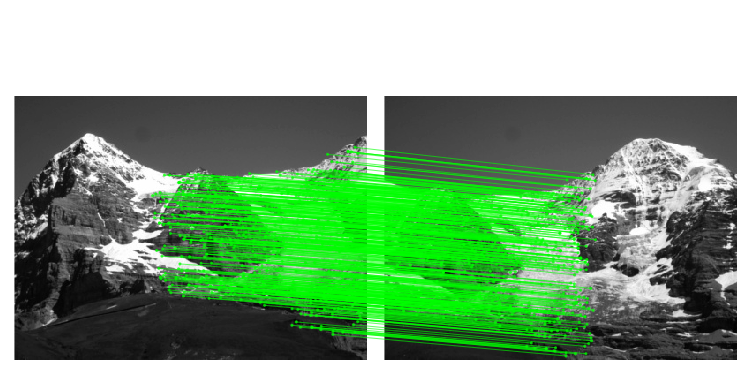

In [9]:
# visualization
# You might need to read the documentation of this function. Or you can write your own drawing function.
from utils import make_matching_figure

fig = make_matching_figure(
    img0,               # The first image
    img1,               # The second image
    np.array(mkpts0),  
    np.array(mkpts1),  
    color=None,         
    kpts0=None,         
    kpts1=None,         
    text=["Good Matches"],  # Optional: text to display on the figure
    dpi=75,             # Set the resolution of the output figure
    path=None           # If you want to save the output, provide the path; otherwise it returns the figure
)


---

## Part II: Image Stitching

One application fo image matching is to stitch multiple images and get one panorama.

### Task 3: Transformation

Considering 2 images as input, you can use SIFT (provided by cv2) to find the transformation between them (implement it on your own).

In [10]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [11]:
# load an image
img0 = cv2.imread("1.jpeg", cv2.IMREAD_GRAYSCALE)
img1 = cv2.imread("2.jpeg", cv2.IMREAD_GRAYSCALE)

In [12]:
# compute SIFT keypoints and descriptors
# note: on gray image

#copy code from above
# creat sift extractor (detector + descriptor)
SIFT = cv2.SIFT_create()
# get the detector and descriptor
kpts0, descs0 = SIFT.detectAndCompute(img0, None)
kpts1, descs1 = SIFT.detectAndCompute(img1, None)

#create a matcher
matcher = cv2.BFMatcher_create(cv2.NORM_L2)
# match descriptors
matches = matcher.knnMatch(descs0, descs1,2)
# calculate good matches
good_matches = []
for m,n in matches:
    if m.distance < 0.7 * n.distance:
        good_matches.append(m)

mkpts0= [kpts0[m.queryIdx].pt for m in good_matches]#queryidx is the index of the descriptor in the first image
mkpts1= [kpts1[m.trainIdx].pt for m in good_matches]#trainidx is the index of the descriptor in the second image

# print(len(good_matches))
# print(len(mkpts0))
# print(mkpts0)
# print(len(mkpts1))
# print(mkpts1)

Here, the transformation $H$ is defined as 
$$\begin{bmatrix}x_0\\y_0\\1\end{bmatrix}=\begin{bmatrix}h_{11}&h_{12}&h_{13}\\h_{21}&h_{22}&h_{23}\\0&0&1\end{bmatrix}\begin{bmatrix}x_1\\y_1\\1\end{bmatrix}$$

Please answer:

(1) What type is this transformation?

(2) Please write down the converted equation in the form of $Ah=b$. To solve this equation, what's the minimal number of matches we need? 

 <span style="color:red">
 
 
Answer1:  
This is the affine transformation.  

Answer2:  

$$ \left[
\begin{matrix}
x_1&y_1&1&0&0&0\\
0&0&0&x_1&y_1&1\\
\end{matrix}
\right] \left[
\begin{matrix}
h_{11}\\
h_{12}\\
h_{13}\\
h_{21}\\
h_{22}\\
h_{23}\\
\end{matrix}
\right] 
=\left[ \begin{matrix}
x_0 \\
y_0 \\
\end{matrix}
\right] $$

At least 3 matches are needed.
</span> 

 

In [28]:
# Randomly select 3 matches (ensuring we don't select more than available)
num_matches = min(3, len(good_matches))  # In case there are fewer than 3 good matches
indices = np.random.choice(len(good_matches), num_matches, replace=False)

# Select the corresponding keypoints based on the random indices
selected_mkpts0 = []
selected_mkpts1 = []
for i in indices:
    selected_mkpts0.append(mkpts0[i])
    selected_mkpts1.append(mkpts1[i])


# Construct the matrix A for the homography calculation
A = []
b = []
for i in range(num_matches):
    x1, y1 = selected_mkpts0[i]
    x2, y2 = selected_mkpts1[i]
    A.append([x1, y1, 1, 0, 0, 0])    
    A.append([0, 0, 0, x1, y1, 1])   
    b.append(x2)    
    b.append(y2)

A = np.array(A)
b = np.array(b)


# solve the equation
A_inv = np.linalg.pinv(A)
h = np.dot(A_inv, b)

print(h)

[ 1.01527302e+00  8.39190517e-02 -1.62413005e+02  4.49440304e-02
  9.51421254e-01  1.64663023e+01]


### Task 4: RANSAC

To use naive ransac algorithm, we need $N$ sample-points(样本点), to solve the model, we need $K$ sample-points as a minimal requirement. Then perform:

1. Randomly sample $K$ sample-points.
2. Fit the model with $K$ sample-points. Denoted as $\hat h$.
3. Compute error of other sample points according to $\hat h$. Count the inliers within some threshold.
4. Repeat $M$ times, the final $h$ is the $\hat h$ with most inliers. 

In [31]:
# implement your own RANSAC
def ransac_to_estimate_H(good_matches, K, inlier_thr, M, mkpts0, mkpts1): 
    best_H = None
    max_inliers = 0

    for i in range(M):
        #########################################################################
        # Randomly select 3 matches (ensuring we don't select more than available) and calculate the homography matrix
        #########################################################################
        indices = np.random.choice(len(good_matches), K, replace=False)
        # Select the corresponding keypoints based on the random indices
        selected_mkpts0 = []
        selected_mkpts1 = []
        for i in indices:
            selected_mkpts0.append(mkpts0[i])
            selected_mkpts1.append(mkpts1[i])
        # Construct the matrix A for the homography calculation
        A = []
        b = []
        for i in range(K):
            x1, y1 = selected_mkpts0[i]
            x2, y2 = selected_mkpts1[i]
            A.append([x1, y1, 1, 0, 0, 0])    
            A.append([0, 0, 0, x1, y1, 1])   
            b.append(x2)    
            b.append(y2)
        A = np.array(A)
        b = np.array(b)
        # print(A.shape)
        # print(b.shape)
        # solve the equation
        A_inv = np.linalg.pinv(A)
        h = np.dot(A_inv, b)
        
        #########################################################################
        # calculate inliers with the found homography matrix and update the best one
        #########################################################################
        inliers = 0
        for i in range(len(good_matches)):
            x1, y1 = mkpts0[i]
            x2, y2 = mkpts1[i]
            AA = []
            AA.append([x1, y1, 1, 0, 0, 0])    
            AA.append([0, 0, 0, x1, y1, 1])   
            AA = np.array(AA)
            RESULT = np.dot(AA, h)
            x2_ = RESULT[0]
            y2_ = RESULT[1]      
            if np.sqrt((x2 - x2_)**2 + (y2 - y2_)**2) < inlier_thr:
                inliers += 1
        if inliers > max_inliers:
            max_inliers = inliers
            best_H = h  
    return best_H

h = ransac_to_estimate_H(good_matches, 3, 5, 1000, mkpts0, mkpts1)
print(h)

[ 9.95949080e-01 -5.43623817e-02 -1.41589467e+02  3.97462143e-02
  9.75231775e-01  1.56700192e+01]


[[ 9.95949080e-01 -5.43623817e-02 -1.41589467e+02]
 [ 3.97462143e-02  9.75231775e-01  1.56700192e+01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


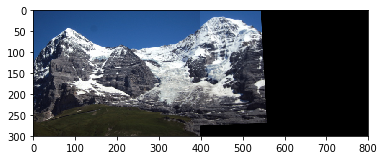

In [45]:
H=np.zeros((3,3))
H[0]=h[0:3]
H[1]=h[3:6]
H[2]=[0,0,1]
print(H)

# use cv2.warpPerspective to put one image on the other
img0_rgb = cv2.imread("1.jpeg", cv2.IMREAD_COLOR)[..., [0, 1, 2]]
img1_rgb = cv2.imread("2.jpeg", cv2.IMREAD_COLOR)[..., [0, 1, 2]]
# use cv2.warpPerspective to put one image on the other
height, width, channels = img0_rgb.shape
dsize = (width * 2, height)
panorama = cv2.warpPerspective(img1_rgb, np.linalg.inv(H), dsize)
panorama[:, :width] = img0_rgb

# use plt to visualize the results
plt.imshow(panorama[..., [2, 1, 0]])

How to solve the artifacts in the overlapping region? Name 2 possible methods.

 <span style="color:red">
 
 
 Answer:  
 1.Blending Techniques  
 2.Histogram Equalization
 
 
 </span>